In [4]:
using PyPlot
using Distributions
using StatsBase
using GWASTools
using HDF5

In [24]:
pop, dosage, COR = h5open("samplepop.hdf5","r") do x
    convert(Matrix{Bool},read(x,"pop")), convert(Matrix{Int},read(x, "dosage")), read(x, "COR")
end;
Nsnp, Nind = size(dosage)

(1600,2000)

In [123]:
function maf(pop::Matrix)
    mm = mean(pop,2)
    min(mm, 1-mm)
end
selected = maf(pop) .> 0.2;

In [124]:
sd = dosage#[selected,:]

1600x2000 Array{Int64,2}:
 2  2  2  1  2  1  1  1  1  2  2  2  1  …  2  2  2  2  1  2  2  2  2  1  2  1
 1  2  2  2  1  2  1  2  1  2  1  1  2     2  2  2  2  2  1  2  2  2  1  1  2
 1  1  0  1  1  0  0  1  1  1  1  1  0     2  2  1  1  0  1  2  1  1  0  1  0
 1  2  0  2  1  1  1  2  1  2  1  1  2     1  2  1  2  2  1  2  2  2  1  1  1
 2  2  2  1  2  1  1  1  2  2  2  2  1     2  2  2  2  1  2  2  2  2  1  2  1
 2  2  2  1  2  1  1  1  2  2  2  2  1  …  2  2  2  2  1  2  2  2  2  1  2  1
 1  1  2  1  1  2  2  1  1  1  1  1  1     1  0  1  0  1  1  0  1  0  2  2  2
 2  1  2  1  2  1  0  1  2  1  2  2  1     2  2  2  2  1  2  2  1  2  1  1  1
 1  1  2  1  1  2  2  1  2  1  1  1  1     1  0  1  0  1  1  0  1  0  2  2  2
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  0  0  0  0  0  0  0  0  0  0  0
 2  2  0  2  2  2  2  2  2  2  2  2  2  …  1  2  2  2  2  2  2  2  2  2  2  1
 1  0  0  1  1  2  2  1  1  0  1  1  1     0  0  1  0  1  1  0  0  0  2  1  1
 2  2  2  2  1  2  2  2  2  2  2  2  2

calculating GWAS z-scores ...100% Time: 0:00:02

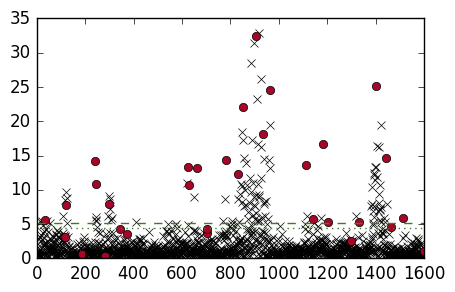

In [127]:
function assign_cases(dosage::Matrix, risksnpfraction::Float64, casesfraction::Float64)
    Nsnp, Nind = size(dosage)
    Nrisk = Int(round(risksnpfraction*Nsnp))
    
    riskind = sample(1:Nsnp,Nrisk,replace=false)
    risk = zeros(Float64,Nsnp)
    risk[riskind] = rand(Nrisk) + 1

    score = Array(Float64,Nind)
    for i in 1:Nind
        score[i]=dot(risk, dosage[:,i])
    end 

    casesind = sortperm(score, rev=true)[1:Int(casesfraction*Nind)]
    cases = zeros(Bool,Nind)
    cases[casesind] = true 
    
    risk, cases
end

risk, cases = assign_cases(sd, 0.02, 0.4);
zscores = GWAS(sd, cases);
manhattanplot(zscores, risk .> 0);

In [122]:
fig = plt[:figure](figsize=(5,3))
ax = fig[:add_subplot](111)
ax[:plot](snpnumber[~highlight], neglogp[~highlight], "xk")
ax[:plot](snpnumber[highlight], neglogp[highlight], "o", color=RED)

817-element Array{Float64,1}:
  -3.69224 
 -11.1498  
  -4.61693 
  -5.76476 
  -5.98609 
   8.71628 
  -6.04041 
   8.13788 
   3.80508 
   8.67939 
   8.56445 
  -5.85607 
   5.78867 
   ⋮       
  -0.666002
   0.187976
  -0.496254
  -1.13062 
  -1.51861 
  -0.436156
  -0.275284
   2.14417 
  -1.10736 
  -1.27366 
  -2.27164 
   0.557838

In [26]:
zscores

1600-element Array{Float64,1}:
  0.423467
 -0.572844
  1.22865 
 -1.99429 
 -0.320032
 -0.27865 
 -1.97898 
  3.01886 
 -1.14312 
  1.09587 
 -1.97854 
  0.271701
 -0.234467
  ⋮       
  0.286912
 -0.816275
 -0.423857
  0.235954
 -0.383793
  1.7391  
 -0.555208
 -0.503242
 -2.43367 
 -2.25748 
  2.33007 
 -1.70233 